# ERA5 access via the CDS API

The [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) run through the [European Center for Medium-Range Weather Forecasts](https://www.ecmwf.int/) provides a great API and associated python package for accessing the eight different ERA5 datasets they host. This notebook will demonstrate using this API to retrieve some of this data.

#### Using the CDS API

To use the CDS API, you must [register](https://cds.climate.copernicus.eu/user/register) for API service through the link to the CDS above, and [follow the instructions](https://cds.climate.copernicus.eu/api-how-to) to ensure your credentials properly set up and visible for the python instance. 

## Downloading ERA5 data

The way to submit an API request is with the `retrieve` method of the `cdsapi.api.Client` object. It accepts a dataset name and a dictionary of arguments which can be derived with the help of the "show API request" option on the download form for any of the ERA5 datasets. For example, [here is the form](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form) for downloading from the "ERA5 hourly data on single levels from 1940 to present" dataset.

In [1]:
import cdsapi
import xarray as xr
import pandas as pd
from pathlib import Path

Below is an example request for 2m temperature data for 1980-01-01 for a bounding box containing most of Alaska (minus Aleutians west of the antimeridian):

In [2]:
c = cdsapi.Client()

c.retrieve(
    "reanalysis-era5-single-levels",  # name of the dataset
    {  # parameters for the request
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": "2m_temperature",
        "year": "1980",
        "month": "01",
        "day": "01",
        "time": "00:00",
        "area": [
            72,
            -180,
            50,
            -120,
        ],
    },
    "download.nc",  # download filename
)

2023-11-13 10:21:22,222 INFO Welcome to the CDS
2023-11-13 10:21:22,223 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-13 10:21:22,526 INFO Request is completed
2023-11-13 10:21:22,528 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data1/adaptor.mars.internal-1699898412.0725114-16949-19-490c3887-398e-4452-ac7a-321c1236cb9a.nc to download.nc (44.2K)
2023-11-13 10:21:24,012 INFO Download rate 29.8K/s  


Result(content_length=45296,content_type=application/x-netcdf,location=https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data1/adaptor.mars.internal-1699898412.0725114-16949-19-490c3887-398e-4452-ac7a-321c1236cb9a.nc)

This downloads the data to a file called `download.nc` in the current working directory:

In [3]:
ds = xr.open_dataset("download.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 89, time: 1)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -120.5 -120.2 -120.0
  * latitude   (latitude) float32 72.0 71.75 71.5 71.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1980-01-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-13 18:00:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Have a look at this data:

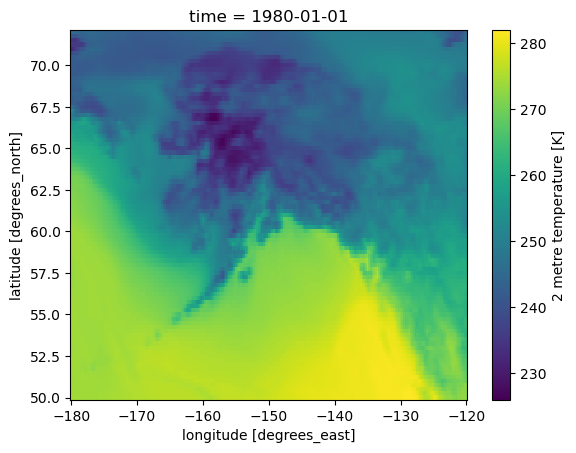

In [4]:
ds["t2m"].plot()

#### Target download directory

Note, this tool currently just writes the downloaded data to a specified file name. So you may want to set up a path for a directory for writing these files. E.g.:

In [5]:
era5_dir = Path("./ERA5_data")
era5_dir.mkdir(exist_ok=True)

#### Download with multiple dates and times

If we want to get downloads for multiple dates and / or times, we simply supply a list of the different temporal values we are seeking. For example, here is a request for 2m temperature at 12:00pm on January 1 for each year in 1980-2009:

In [6]:
download_path = era5_dir.joinpath("t2m_Jan1noon_1980-2009.nc")
ak_bbox = [72, -180, 50, -120]
params = {
    "product_type": "reanalysis",
    "format": "netcdf",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(1980, 2010)],
    "month": "01",
    "day": "01",
    "time": "12:00",
    "area": ak_bbox,
}
c.retrieve("reanalysis-era5-single-levels", params, download_path)

2023-11-13 10:21:25,145 INFO Welcome to the CDS
2023-11-13 10:21:25,147 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-13 10:21:25,498 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data4/adaptor.mars.internal-1699898431.0302505-21544-5-554e461a-55c7-4865-80b8-73dcef45fc0e.nc to ERA5_data/t2m_Jan1noon_1980-2009.nc (1.2M)
2023-11-13 10:21:27,979 INFO Download rate 507.8K/s 


Result(content_length=1289452,content_type=application/x-netcdf,location=https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data4/adaptor.mars.internal-1699898431.0302505-21544-5-554e461a-55c7-4865-80b8-73dcef45fc0e.nc)

We can verify that the file has the expected datetimes:

In [7]:
ds = xr.open_dataset(download_path)
ds.time.values

array(['1980-01-01T12:00:00.000000000', '1981-01-01T12:00:00.000000000',
       '1982-01-01T12:00:00.000000000', '1983-01-01T12:00:00.000000000',
       '1984-01-01T12:00:00.000000000', '1985-01-01T12:00:00.000000000',
       '1986-01-01T12:00:00.000000000', '1987-01-01T12:00:00.000000000',
       '1988-01-01T12:00:00.000000000', '1989-01-01T12:00:00.000000000',
       '1990-01-01T12:00:00.000000000', '1991-01-01T12:00:00.000000000',
       '1992-01-01T12:00:00.000000000', '1993-01-01T12:00:00.000000000',
       '1994-01-01T12:00:00.000000000', '1995-01-01T12:00:00.000000000',
       '1996-01-01T12:00:00.000000000', '1997-01-01T12:00:00.000000000',
       '1998-01-01T12:00:00.000000000', '1999-01-01T12:00:00.000000000',
       '2000-01-01T12:00:00.000000000', '2001-01-01T12:00:00.000000000',
       '2002-01-01T12:00:00.000000000', '2003-01-01T12:00:00.000000000',
       '2004-01-01T12:00:00.000000000', '2005-01-01T12:00:00.000000000',
       '2006-01-01T12:00:00.000000000', '2007-01-01

And so we can compute a climatology for January 1st from this data:

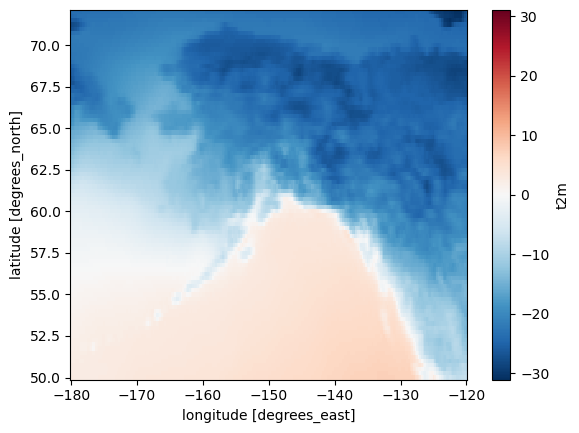

In [8]:
# converted to Celsius
(ds["t2m"].mean(dim="time") - 273.15).plot()

### Downloading all data withing temporal range

Given that the format required for the API utilizes discrete time values, there is not a great way to request "all data within a given time range". Here is a trick to do so programmatically with python, using `pandas`: create a `DatetimeIndex` using the `date_range` function, and parse out the different values for each time unit:

In [9]:
date_range = pd.date_range("1980-01-01", "1980-01-31", freq="1h")
time_params = {
    "time": date_range.strftime("%H:%M").unique().to_list(),
    "year": date_range.strftime("%Y").unique().to_list(),
    "month": date_range.strftime("%m").unique().to_list(),
    "day": date_range.strftime("%d").unique().to_list(),
}

This snippet has been included in a function in the `ardac_utils.py` module for convenience. 

In [10]:
from ardac_utils import cdsapi_timerange_params


time_params = cdsapi_timerange_params(
    start_time="1980-01-01", end_time="1980-01-31", freq="h"
)

Then merge these in with the other required parameters:

In [11]:
download_path = era5_dir.joinpath("t2m_1980.nc")

ak_bbox = [72, -180, 50, -120]
params = {
    "product_type": "reanalysis",
    "format": "netcdf",
    "variable": "2m_temperature",
    "area": ak_bbox,
}
params.update(time_params)
c.retrieve("reanalysis-era5-single-levels", params, download_path)

2023-11-13 10:21:28,448 INFO Welcome to the CDS
2023-11-13 10:21:28,449 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-13 10:21:28,760 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.internal-1699898495.471654-26482-9-6278034d-c2b6-43c2-83cc-b988f9fc1d97.nc to ERA5_data/t2m_1980.nc (30.4M)
2023-11-13 10:21:33,954 INFO Download rate 5.9M/s   


Result(content_length=31921480,content_type=application/x-netcdf,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.internal-1699898495.471654-26482-9-6278034d-c2b6-43c2-83cc-b988f9fc1d97.nc)

And verify the times of the downloaded file:

In [12]:
ds = xr.open_dataset(download_path)
print(ds.time.values[:10], end="\n\n")
print(ds.time.values[-10:])

['1980-01-01T00:00:00.000000000' '1980-01-01T01:00:00.000000000'
 '1980-01-01T02:00:00.000000000' '1980-01-01T03:00:00.000000000'
 '1980-01-01T04:00:00.000000000' '1980-01-01T05:00:00.000000000'
 '1980-01-01T06:00:00.000000000' '1980-01-01T07:00:00.000000000'
 '1980-01-01T08:00:00.000000000' '1980-01-01T09:00:00.000000000']

['1980-01-31T14:00:00.000000000' '1980-01-31T15:00:00.000000000'
 '1980-01-31T16:00:00.000000000' '1980-01-31T17:00:00.000000000'
 '1980-01-31T18:00:00.000000000' '1980-01-31T19:00:00.000000000'
 '1980-01-31T20:00:00.000000000' '1980-01-31T21:00:00.000000000'
 '1980-01-31T22:00:00.000000000' '1980-01-31T23:00:00.000000000']


### Working with non-netCDF downloads

The various ERA5 datasets differ slightly in the formats offered for download. For example, the [ERA5-Land hourly data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=form) dataset notes that the netCDF download (non-zipped version) is "not recommended", and they offer a zipped version, along with GRIB. GRIB is also provided for all of the other datasets, and we can use the [GRIB format with `xarray`](https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html) if we have the `cfgrib` engine installed. However, our testing has shown that the `xarray.Dataset` structure when loaded from the GRIB download is not as user-friendly as when loaded from netCDF. So we have provided a helper function in the `ardac_utils.py` module for unzipping the data via python:

In [13]:
download_path = era5_dir.joinpath("era5_land_t2m_19800101.netcdf.zip")

time_params = cdsapi_timerange_params(
    start_time="1980-01-01", end_time="1980-01-01 23:00:00", freq="h"
)
ak_bbox = [72, -180, 50, -120]
params = {
    "format": "netcdf.zip",
    "variable": "2m_temperature",
    "area": ak_bbox,
}
params.update(time_params)
c.retrieve("reanalysis-era5-land", params, download_path)

2023-11-13 10:21:34,277 INFO Welcome to the CDS
2023-11-13 10:21:34,278 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-11-13 10:21:34,557 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data9/adaptor.mars.internal-1699898561.243147-25721-14-d968e15f-3998-46d7-8e7e-b2ca185baf59.zip to ERA5_data/era5_land_t2m_19800101.netcdf.zip (2.8M)
2023-11-13 10:21:37,563 INFO Download rate 947.9K/s 


Result(content_length=2915856,content_type=application/zip,location=https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data9/adaptor.mars.internal-1699898561.243147-25721-14-d968e15f-3998-46d7-8e7e-b2ca185baf59.zip)

Once we have the `.zip` downloaded, we can use the `ardac_utils.unzip` function to unzip the data file to a provided path:

In [14]:
from ardac_utils import unzip


unzip_path = era5_dir.joinpath(download_path.name.replace(".netcdf.zip", ".nc"))
unzip(download_path, unzip_path)
ds = xr.open_dataset(unzip_path)
ds

<xarray.Dataset>
Dimensions:    (longitude: 601, latitude: 221, time: 24)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... -120.2 -120.1 -120.0
  * latitude   (latitude) float32 72.0 71.9 71.8 71.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 1980-01-01 ... 1980-01-01T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-13 18:02:41 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

Note the higher resolution of the ERA5-Land:

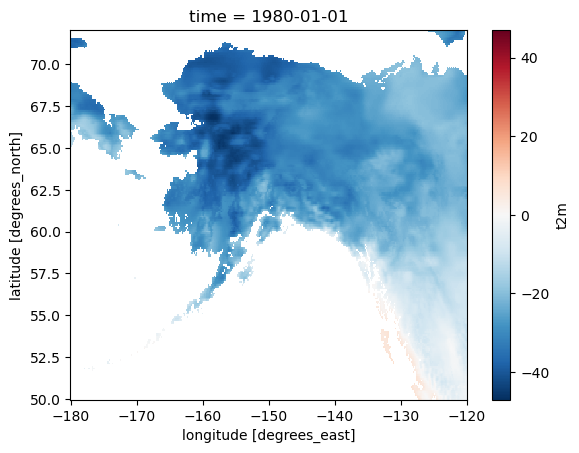

In [15]:
(ds["t2m"].isel(time=0) - 273.15).plot()

### Get ERA5 data for a given location (lat / lon)

If you are interested in data at whatever pixel intersects a particular point, you can just repeat the latitude and longitude of interest for the `bbox` parameter:

In [16]:
user_lat = 64.84
user_lon = -147.72
ak_bbox = [user_lat, user_lon, user_lat, user_lon]

download_path = era5_dir.joinpath("era5land_p1.netcdf.zip")

params = {
    "format": "netcdf.zip",
    "variable": "2m_temperature",
    "area": ak_bbox,
    "time": "00:00",
    "year": "1980",
    "month": "01",
    "day": "01",
}
c.retrieve("reanalysis-era5-land", params, download_path)

unzip_path = era5_dir.joinpath(download_path.name.replace(".netcdf.zip", ".nc"))
unzip(download_path, unzip_path)
ds = xr.open_dataset(unzip_path)
ds

2023-11-13 10:21:38,036 INFO Welcome to the CDS
2023-11-13 10:21:38,038 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-11-13 10:21:38,495 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data3/adaptor.mars.internal-1699898610.3261557-7486-14-e41055e3-f0a0-4a3a-940d-18b53f3b7757.zip to ERA5_data/era5land_p1.netcdf.zip (622)
2023-11-13 10:21:38,746 INFO Download rate 2.4K/s


<xarray.Dataset>
Dimensions:    (longitude: 1, latitude: 1, time: 1)
Coordinates:
  * longitude  (longitude) float32 -147.7
  * latitude   (latitude) float32 64.84
  * time       (time) datetime64[ns] 1980-01-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-13 18:03:30 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

### Get ERA5 data for a table of locations

One common operation is to extract data at the pixels which intersect a ser of locations of interest from a reanalysis such as ERA5. Here is an example of this. We will construct a table with columns "latitude" and "longitude" for some locations of interest, then we will iterate over these locations to make multiple requests to the API to get monthly-averaged ERA5-data data values for a single time period, 1980-2009.

Construct the table, which could be loaded in as a CSV instead:

In [17]:
df = pd.DataFrame(
    {
        "latitude": [64.82, 61.18, 58.36],
        "longitude": [-147.86, -149.99, -134.58],
        "name": ["Fairbanks", "Anchorage", "Juneau"],
    }
).set_index("name")
df

,latitude,longitude
name,,
Fairbanks,64.82,-147.86
Anchorage,61.18,-149.99
Juneau,58.36,-134.58


Define our params we will re-use for each location. Start with the time parameters, note we change the `freq` argument in our time parameters function to "m" for month:

In [18]:
params = {
    "format": "netcdf.zip",
    "variable": "2m_temperature",
}

time_params = cdsapi_timerange_params(
    start_time="2000-01-01", end_time="2009-12-31 00:00:00", freq="m"
)
params.update(time_params)
# template download filename
tmp_download_fn = "era5land_{}_2000-2009.netcdf.zip"

Create a new table for populating with extracted values:

In [19]:
data_df = pd.DataFrame()

Iterate and download (and unzip), open the file as an `xarray.Dataset` and pull out the values into a table:

In [20]:
for name, row in df.iterrows():
    bbox = [row["latitude"], row["longitude"], row["latitude"], row["longitude"]]
    params.update({"area": bbox})
    download_path = era5_dir.joinpath(tmp_download_fn.format(name))
    c.retrieve("reanalysis-era5-land-monthly-means", params, download_path)

    unzip_path = era5_dir.joinpath(download_path.name.replace(".netcdf.zip", ".nc"))
    unzip(download_path, unzip_path)

    with xr.open_dataset(unzip_path) as ds:
        data_df[name] = ds.t2m.values.flatten() - 273.15

2023-11-13 10:21:39,290 INFO Welcome to the CDS
2023-11-13 10:21:39,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means
2023-11-13 10:21:39,584 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data8/adaptor.mars.internal-1699901916.7604914-12071-7-94857ad8-120d-440d-a4fc-669d045973c4.zip to ERA5_data/era5land_Fairbanks_2000-2009.netcdf.zip (1.7K)
2023-11-13 10:21:40,577 INFO Download rate 1.8K/s
2023-11-13 10:21:41,093 INFO Welcome to the CDS
2023-11-13 10:21:41,094 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means
2023-11-13 10:21:41,370 INFO Request is queued
2023-11-13 10:21:42,621 INFO Request is running
2023-11-13 10:24:35,109 INFO Request is completed
2023-11-13 10:24:35,110 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data9/adaptor.mars.internal-1699903443.976962-23794-1

And we can add the time values as an index:

In [21]:
# all should have the same time series
data_df["time"] = ds.t2m.time.values
data_df = data_df.set_index("time")
data_df.head()

,Fairbanks,Anchorage,Juneau
time,,,
2000-01-01,-21.675446,-9.795715,-7.964600
2000-01-02,-20.732086,-9.058624,-7.446808
2000-02-01,-11.803894,-2.839264,-3.615601
2000-02-02,-8.843445,-0.743958,-1.909271
2000-03-01,-6.827515,-1.296448,-1.915375


And check out a plot! Looks as we would expect, with Fairbanks having the most variation to Juneau having the least.

<Axes: xlabel='time'>

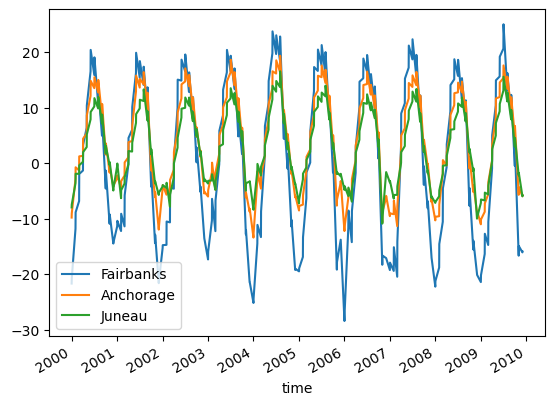

In [22]:
data_df.plot()